# Proof of concept
This notebook shows how the naive application of compression techniques can lead to reductions in parameters and model size, without significant loss in accuracy.

In [1]:
import sys
import torch
import importlib
import inspect
import matplotlib.pyplot as plt
import numpy as np
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# Add thesis package to path
sys.path.append("../")

import src.general as general
import src.evaluation as eval

### Loading a model
Models can be loaded by providing a model state file and a model class file.

The model state file can be loaded from a ``.pt`` file, or from a ``.pth`` file. It contains the model's state dictionary, which contains the model's parameters.

The model class file can be loaded from a ``.py`` file. It contains a class that inherits from ``torch.nn.Module`` and implements the model architecture.

The tool should work with every model that is supported by PyTorch. 
The ``/models/`` folder contains a few models that can be used for testing.

In [2]:
model_state = "../models/mnist.pt"
model_class = "models.mnist"

# Import the module classes
module = importlib.import_module(model_class)
classes = general.get_module_classes(module)
for cls in classes:
    globals()[cls.__name__] = cls

# Get device
device = general.get_device()

# Load the model
model = torch.load(model_state, map_location=torch.device(device))

Using cuda: False


### Loading dataset

In [3]:
# Load MNIST dataset
batch_size = 8
test_batch_size = 1000
use_cuda = False

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
mnist_transform = transforms.ToTensor()
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform=mnist_transform,),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform=mnist_transform,),
    batch_size=test_batch_size, shuffle=True, **kwargs)


Analyzing the dataset

torch.Size([8, 1, 28, 28])
torch.Size([8])


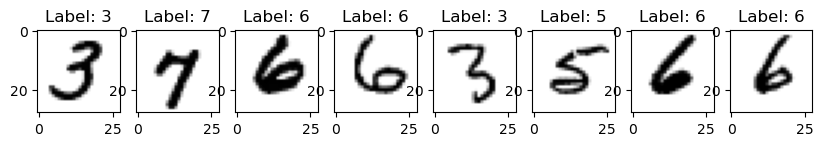

In [4]:
# Get size of element from train_loader
input_batch = next(iter(train_loader))
print(input_batch[0].size()) # Images
print(input_batch[1].size()) # Labels

# Plot all images in batch horizontally next to each other
fig, ax = plt.subplots(1, batch_size, figsize=(10, 10))
for i in range(batch_size):
    ax[i].imshow(input_batch[0][i].numpy().squeeze(), cmap='gray_r')
    ax[i].set_title("Label: {}".format(input_batch[1][i].numpy()))
plt.show()

### Evaluating model before compression
We measure the model's relevant properties such as number of parameters, model size, and number of FLOPs. 
We also measure the accuracy on the test set before compression. 

Calculating the number of FLOPS is not solely dependent on the model. It depends on the model's input size, which depends on the dataset. 
A model's input size is not always fixed. For example, a linear layer has a fixed input size, but a convolutional layer does not.

In [5]:
def get_metrics(model, example_input):
    model_size = eval.get_model_size(model)
    print("Model size (MB): {0:.2f}".format(model_size))

    model_parameters = eval.get_model_parameters(model)
    print("Model parameters: {0}".format(model_parameters))

    # Input size is necessary for FLOPS calculation, but is dependent on the dataset. 
    model_flops, params = eval.get_model_flops(model, example_input.size())
    print("Model FLOPS: {0}".format(model_flops))


input_batch = next(iter(train_loader))
example_input = input_batch[0][0]

get_metrics(model, example_input)

Model size (MB): 1.65
Model parameters: 431080
Model FLOPS: 2.30772M


## Pruning
In this proof of concept we use a simple magnitude pruning technique.

### Magnitude Pruning

In [6]:
import torch.nn.utils.prune as prune
# Define the parameters to prune
parameters_to_prune = (
    (model.conv1, 'weight'),
    (model.conv2, 'weight'),
    (model.fc1, 'weight'),
    (model.fc2, 'weight'),
)

prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.95,
)

Test again after pruning.

In [9]:
get_metrics(model, example_input)


_ = general.test(model, device, test_loader, criterion=torch.nn.CrossEntropyLoss())

Model size (MB): 3.29
Model parameters: 431080
Model FLOPS: 2.30772M


Test: 100%|██████████| 60/60 [00:04<00:00, 13.75it/s]

=============================== TEST PERFORMANCE ===============================
Average loss = 0.4897
Elapsed time = 4366.79 milliseconds (72.78 per batch, 0.07 per data point)
